In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.


In [2]:
limit_mem()

# Basic Style Transfer

In this notebook, we will be implementing Neural Style Transfer, seperating content and style from various images. We can take the content of one image and apply the style (the colors and textures) of a different image to it.

First, let's load our starting images

## Load Images

### Content

In [9]:
path = '/home/ubuntu/StyleGAN/train/'


In [10]:
all_images = glob.glob(path+'*/*'); len(all_images)

1708

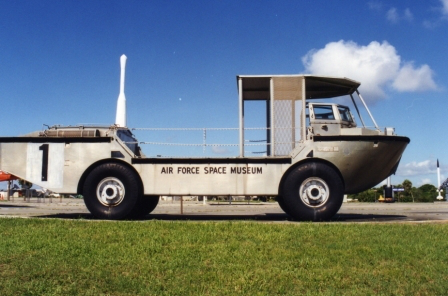

In [13]:
file = all_images[1707]
img = Image.open(file); img

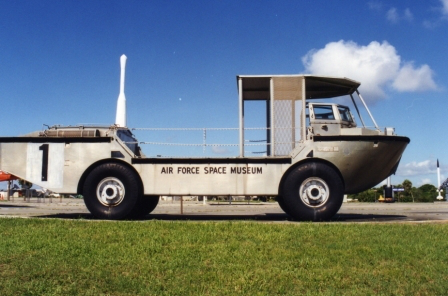

In [16]:
img = Image.open(file); img

In [17]:
img.size

(448, 296)

### Style

Because both images will be going through the same model (do they really need to though...?), we want to resize the style image to the same as the content.

In [20]:
sty_dir = '/home/ubuntu/StyleGAN/starry_night.jpg'

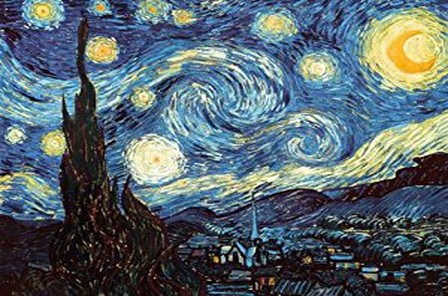

In [21]:
style = Image.open(sty_dir).resize(img.size, Image.ANTIALIAS); style

## Preprocess for VGG

Since we will be using VGG, some preprocessing is necessary. They subtract the mean RGB of ImageNet from each image and reverse the color order to BGR.

In [22]:
rgb_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x : (x - rgb_mean)[:, :, :, ::-1]

To plot, we will need to undo this.

In [23]:
deproc = lambda x, s : np.clip(x.reshape(s)[:, :, :, ::-1] + rgb_mean, 0, 255)

In [24]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
style_arr = preproc(np.expand_dims(np.array(style), 0))

In [25]:
img_shape = img_arr.shape
sty_shape = style_arr.shape
img_shape, sty_shape

((1, 296, 448, 3), (1, 296, 448, 3))

## Build models

In [26]:
input_shape = img_arr.shape[1:]; input_shape

(296, 448, 3)

In [27]:
model = VGG16_Avg(include_top=False, input_shape=input_shape)

/home/ubuntu/StyleGAN/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/home/ubuntu/StyleGAN/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/home/ubuntu/StyleGAN/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/home/ubuntu/StyleGAN/vgg16_avg.py:54: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding="same")`
  x = Conv

### Content

Need to build the outputs.

In [28]:
cont_output = model.get_layer('block5_conv1').output; cont_output

<tf.Tensor 'block5_conv1/Relu:0' shape=(?, 18, 28, 512) dtype=float32>

In [29]:
from keras.models import Model

In [30]:
cont_model = Model(model.input, cont_output)
targ = K.variable(cont_model.predict(img_arr))

In [31]:
class Evaluator(object):
    def __init__(self, func, img_shape): self.func, self.img_shape = func, img_shape
        
    def loss(self, x):
        loss_, self.grad_matrix = self.func([x.reshape(img_shape)])
        return loss_.astype(np.float64)
    
    def grads(self, x): return self.grad_matrix.flatten().astype(np.float64)

In [32]:
loss = K.mean(metrics.mse(cont_output, targ))
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss] + grads)
eval_obj = Evaluator(fn, img_shape)

In [34]:
img_prog_path = '/home/ubuntu/StyleGAN/results/'

In [35]:
def recreate_content(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(), fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127, 127)
        
        print('Current loss value:', min_val)
        imsave(f'{img_prog_path}res_at_iteration_{i}.png', deproc(x.copy(), img_shape)[0])
    return x

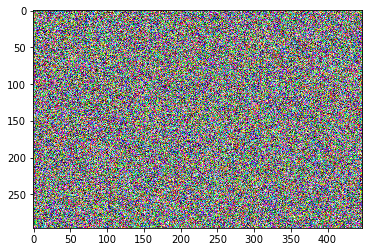

In [36]:
rand_img = lambda shape: np.random.uniform(0, 255, shape)
x = rand_img(img_shape)
plt.imshow(x[0])

In [37]:
iters = 10

In [38]:
x = recreate_content(eval_obj, iters, x)

Current loss value: 75.1757202148
Current loss value: 29.6096935272
Current loss value: 17.5016078949
Current loss value: 12.3873310089
Current loss value: 9.92547702789
Current loss value: 8.45642471313
Current loss value: 7.61411857605
Current loss value: 6.71957826614
Current loss value: 6.14089441299
Current loss value: 5.72153377533


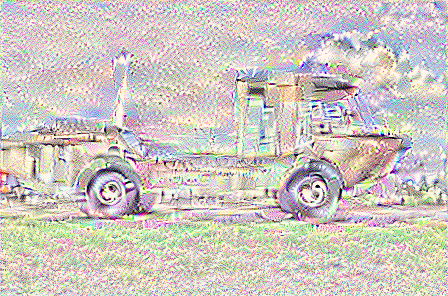

In [39]:
Image.open(img_prog_path+'res_at_iteration_9.png')

In [40]:
from IPython.display import HTML
from matplotlib import animation

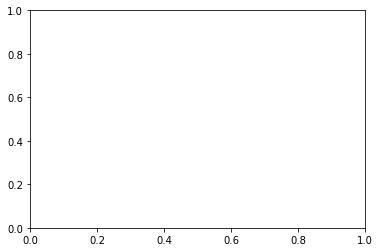

In [41]:
from IPython.display import HTML
from matplotlib import animation
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{img_prog_path}res_at_iteration_{i}.png'))

In [42]:
anim = animation.FuncAnimation(fig,animate, frames = 10, interval = 200)
HTML(anim.to_html5_video())

And that's all she wrote. Now onto style recreation

## Style

In [43]:
def plot_arr(array): plt.imshow(deproc(array, array.shape)[0].astype('uint8'))

Let's remind ourselves what the image looks like

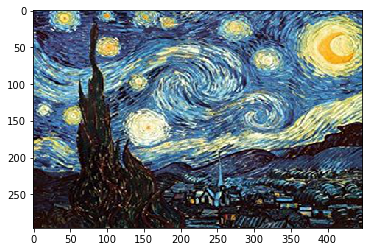

In [44]:
plot_arr(style_arr)

Again, we want to recreate the colors and textures of this image. To begin, the model is going to accept the same thing as input, an image of the same size as before, but output is going to change to multiple layers.

In [45]:
total_conv_blocks = 5

In [46]:
output_dict = {layer.name : layer.output for layer in model.layers}

In [47]:
model_outs = [output_dict['block{}_conv1'.format(o)] for o in range(1, total_conv_blocks + 1)]

In [48]:
model_outs

[<tf.Tensor 'block1_conv1/Relu:0' shape=(?, 296, 448, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 148, 224, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 74, 112, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 37, 56, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1/Relu:0' shape=(?, 18, 28, 512) dtype=float32>]

In [49]:
sty_model = Model(model.inputs, model_outs)
targs = [K.variable(o) for o in sty_model.predict(style_arr)]

To access the 'style', we take a gramian matrix, which is defined as thus:

In [50]:
def gram_matrix(orig_mat):
    # First, change the dimensionality to have RGB channels first, 
    # then flatten along the RGB channels (hence batch_ instead of normal flatten() )
    features = K.batch_flatten(K.permute_dimensions(orig_mat, (2, 0, 1)))
    # This, transposed with itself
    return K.dot(features, K.transpose(features)) / orig_mat.get_shape().num_elements()
    # Dividing by x.get_shape().num_elements() is not strictly necessary,
    # but for our loss function, it is important to have content and style
    # loss on the same scale, hence this division.

In [51]:
def style_loss(x, targs): return metrics.mse(gram_matrix(x), gram_matrix(targs))

In [52]:
loss = sum(K.mean(style_loss(l1[0], l2[0])) for l1, l2 in zip(model_outs, targs))
grads = K.gradients(loss, model.input)
sty_fn = K.function([model.input], [loss] + grads)
eval_obj = Evaluator(sty_fn, sty_shape)

In [53]:
rand_img = lambda shape: np.random.uniform(0, 255, shape)
x = rand_img(sty_shape)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

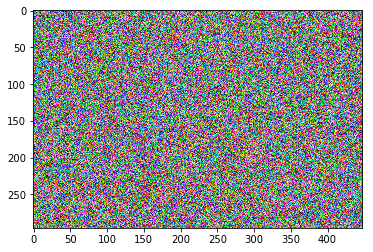

In [54]:
plt.imshow(x[0])

In [55]:
iters = 50

In [56]:
x = recreate_content(eval_obj, iters, x)

Current loss value: 7199.23681641
Current loss value: 1592.96923828
Current loss value: 619.876098633
Current loss value: 318.84197998
Current loss value: 192.051681519
Current loss value: 131.928771973
Current loss value: 92.4034729004
Current loss value: 70.4589538574
Current loss value: 54.9696426392
Current loss value: 46.0811157227
Current loss value: 39.2945594788
Current loss value: 33.5602836609
Current loss value: 28.8501243591


KeyboardInterrupt: 

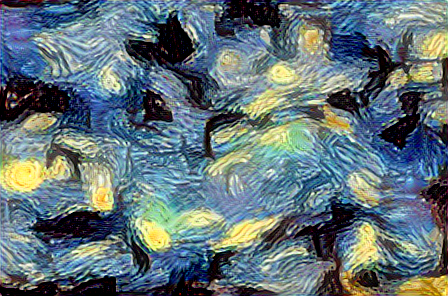

In [57]:
Image.open(f'{img_prog_path}res_at_iteration_12.png')

In [59]:
anim = animation.FuncAnimation(fig,animate, frames = 13, interval = 300)
HTML(anim.to_html5_video())

Not bad! Alright, now to combine style and content loss into a singular function.

# Bringing it all together

To understand how all the parts fit in together, we will clear and redeclare all relavent variables.

In [60]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [61]:
%matplotlib inline
import utils2
from keras.models import Model
import keras.backend as K
import numpy as np

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from scipy.ndimage import gaussian_filter
from keras import metrics
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

from vgg16_avg import VGG16_Avg

In [62]:
utils2.limit_mem()

## Load Images

### Content

In [63]:
imagenet_imgs = glob('/home/ubuntu/StyleGAN/train/*/*'); len(imagenet_imgs)

1708

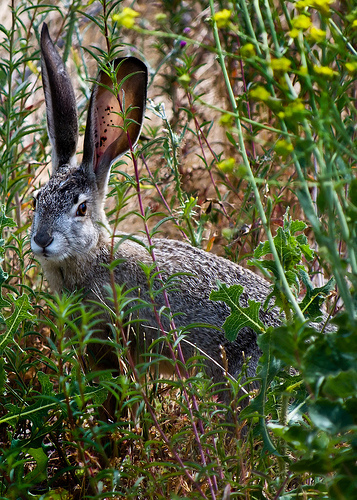

In [70]:
img = Image.open(imagenet_imgs[24]); img

In [105]:
size = img.size; size

(357, 500)

### Style

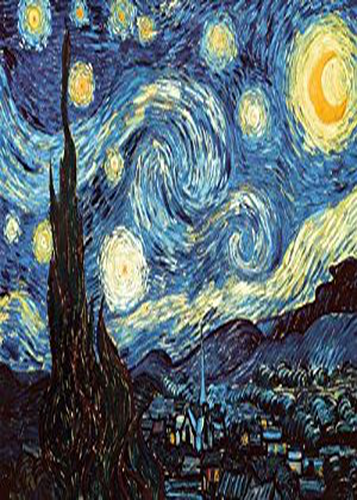

In [72]:
sty = Image.open('/home/ubuntu/StyleGAN/starry_night.jpg').resize(size, Image.ANTIALIAS); sty

## VGG Preprocess

In [73]:
rgb_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: np.array(x - rgb_mean)[:, :, :, ::-1]

In [74]:
deproc = lambda x, shape: np.clip(x.reshape(shape)[:, :, :, ::-1] + rgb_mean, 0, 255)

In [75]:
img_arr = preproc(np.expand_dims(img, 0))
sty_arr = preproc(np.expand_dims(sty, 0))
shape = img_arr.shape; shape

(1, 500, 357, 3)

## Build the model

In [76]:
model = VGG16_Avg(include_top=False, input_shape=shape[1:])

/home/ubuntu/StyleGAN/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/home/ubuntu/StyleGAN/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/home/ubuntu/StyleGAN/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/home/ubuntu/StyleGAN/vgg16_avg.py:54: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding="same")`
  x = Conv

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500, 357, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 357, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 357, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 250, 178, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 178, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 178, 128)     147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 125, 89, 128)      0         
__________

In [78]:
name2output = {l.name: l.output for l in model.layers}

In [106]:
outputs = [name2output['block{}_conv2'.format(o)] for o in range(1,6)]


[<tf.Tensor 'block1_conv2_1/Relu:0' shape=(?, 500, 357, 64) dtype=float32>,
 <tf.Tensor 'block2_conv2_1/Relu:0' shape=(?, 250, 178, 128) dtype=float32>,
 <tf.Tensor 'block3_conv2_1/Relu:0' shape=(?, 125, 89, 256) dtype=float32>,
 <tf.Tensor 'block4_conv2_1/Relu:0' shape=(?, 62, 44, 512) dtype=float32>,
 <tf.Tensor 'block5_conv2_1/Relu:0' shape=(?, 31, 22, 512) dtype=float32>]

In [80]:
nst_model = Model(model.input, outputs)

This time, I'm going to take content loss from the same layers I take style loss from in order to use the same model. We'll see how it comes out.

In [81]:
cont_targs = [K.variable(o) for o in nst_model.predict(img_arr)]
sty_targs = [K.variable(o) for o in nst_model.predict(sty_arr)]

## Define loss/grad, etc.

Let's remind ourselves that for style loss, we take the sum if the mse of the gram matrix for our target and noise. Let's redefine that here.

In [82]:
K.batch_flatten()

TypeError: batch_flatten() missing 1 required positional argument: 'x'

In [83]:
def gram_mat(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [84]:
def sty_loss(targ, layer): return K.mean(metrics.mse(gram_mat(targ), gram_mat(layer)))

We now need to define the loss functions for both content and style. The only real difference between these two losses is that the style transfer goes through the gramian matrix function.

In [85]:
cont_loss = sum(K.mean(metrics.mse(cont_targ[0], cont_outp[0])) 
                for cont_targ, cont_outp in zip(cont_targs, outputs))
style_loss = sum(sty_loss(sty_targ[0], sty_outp[0]) 
                 for sty_targ, sty_outp in zip(sty_targs, outputs))

In [86]:
loss = cont_loss + style_loss
grad = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grad)

In [87]:
class Evaluator(object):
    def __init__(self, func, shape): self.func, self.shp = func, shape
    
    def loss(self, x):
        loss_, self.grads_ = self.func([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x): return self.grads_.flatten().astype(np.float64)

In [88]:
eval_obj = Evaluator(fn, shape)

## Create Noise

In [89]:
noise = lambda shape: np.random.uniform(0, 225, size=shape)
x = noise(shape)
plt.imshow(x[0].astype('uint8'));

In [90]:
#x = img

In [91]:
#x = np.expand_dims(x, 0)

In [92]:
#x.shape

## Define training loop and train

In [93]:
def train(x, shape, eval_obj, iters):
    for i in range(iters):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(), 
                                         fprime=eval_obj.grads, maxfun=20)
        np.clip(x, -127, 127)
        print('Current loss: {}'.format(min_val))
        imsave(f'./results/res_at_iteration_{i}.png', deproc(x.copy(), shape)[0])
    return x

In [94]:
iters = 100
x = train(x, shape, eval_obj, iters)

Current loss: 92210.53125
Current loss: 63225.01171875
Current loss: 57084.625
Current loss: 54459.125
Current loss: 52761.1875
Current loss: 51704.94140625
Current loss: 51058.9609375
Current loss: 50641.390625
Current loss: 50376.63671875
Current loss: 50201.10546875
Current loss: 50073.140625
Current loss: 49975.0625
Current loss: 49894.63671875
Current loss: 49827.33203125
Current loss: 49769.984375
Current loss: 49719.328125
Current loss: 49674.66015625
Current loss: 49634.5546875
Current loss: 49599.171875
Current loss: 49566.9375
Current loss: 49538.30078125
Current loss: 49512.1328125
Current loss: 49488.6796875
Current loss: 49467.2421875
Current loss: 49447.6796875
Current loss: 49429.7109375
Current loss: 49412.0859375
Current loss: 49395.3828125
Current loss: 49380.0
Current loss: 49365.8125


KeyboardInterrupt: 

## Visualize Results

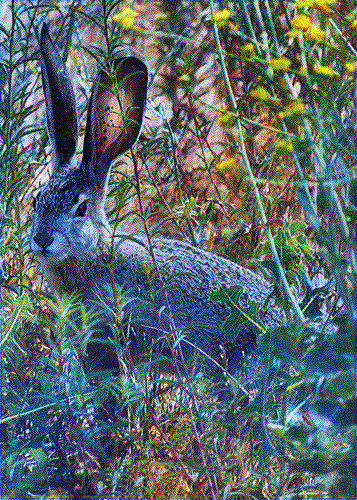

In [98]:
result = Image.open('./results/res_at_iteration_2.png'); result

In [99]:
import IPython.display as disp

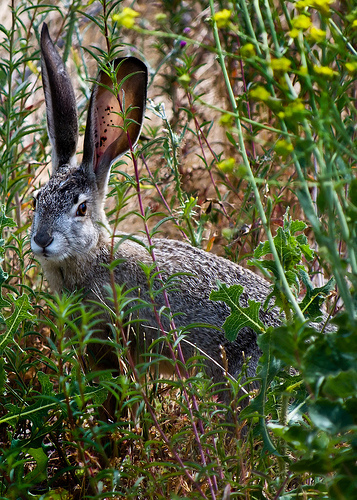

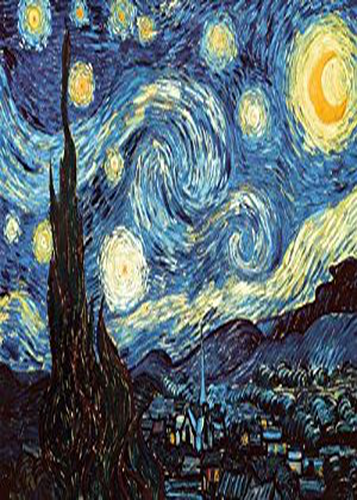

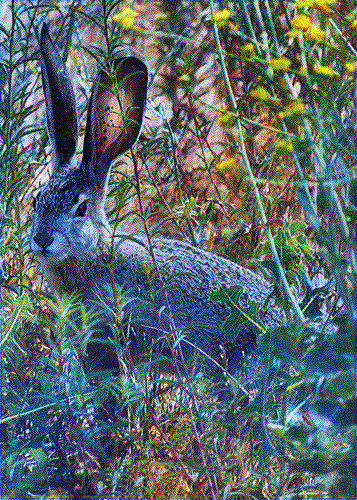

In [100]:
disp.display(img, sty, result)

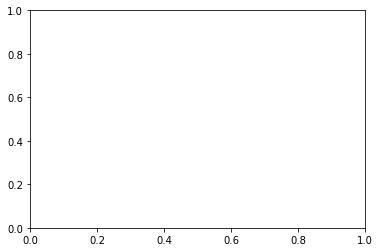

In [101]:
img_prog_path = './results/'
from IPython.display import HTML
from matplotlib import animation
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{img_prog_path}res_at_iteration_{i}.png'))

In [103]:
anim = animation.FuncAnimation(fig,animate, frames = 29, interval = 100)
HTML(anim.to_html5_video())